In [1]:
import sys
import os
current_dir = os.getcwd()
root_dir = os.path.dirname(current_dir)
sys.path.insert(0, str(root_dir))

import spatialzoomer as sz
import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

C:\Users\fyh\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


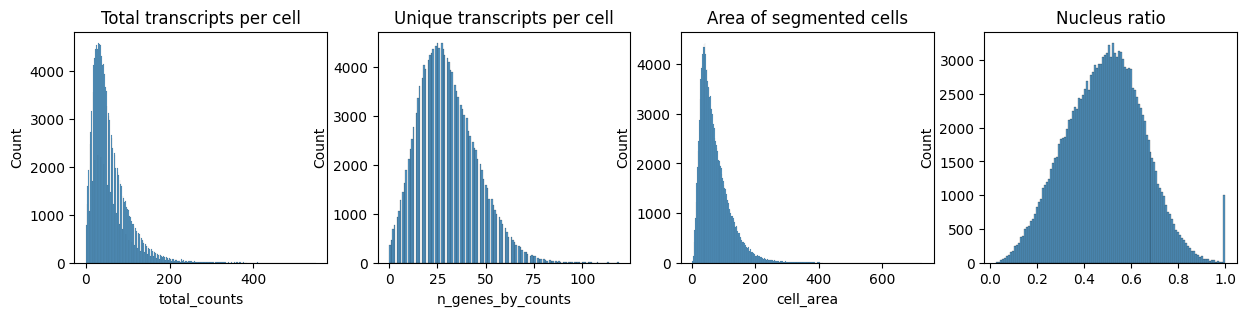

In [2]:
adata = sc.read_h5ad("C:/Projects/SpatialZoomer/data/XeniumLungCancer_Raw.h5ad")
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
sz.plot_qc_hist(adata)

In [3]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
adata = adata[~adata.obs['nucleus_area'].isna(), :]


adata = sz.Preprocess(adata)    # lognorm
adata

AnnData object with n_obs × n_vars = 149195 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatialdata_attrs', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
adata = sz.performDR(adata, type = 'NMF', n_components=50)    # key: 'X_nmf'

Time taken to perform NMF: 25.2931 seconds


Maximum similarities:  43.80892354771157
Minimum similarities:  0.29271039388856557
Median similarities:  4.999999999964153
time taken to construct spatial_knn: 0.4562 seconds
Time taken to perform spectral graph filter bank: 120.6504 seconds
Transformed signals saved to ./results/XeniumLungCancer_neighbor10_TEST/XeniumLungCancer_transformed_signals.h5


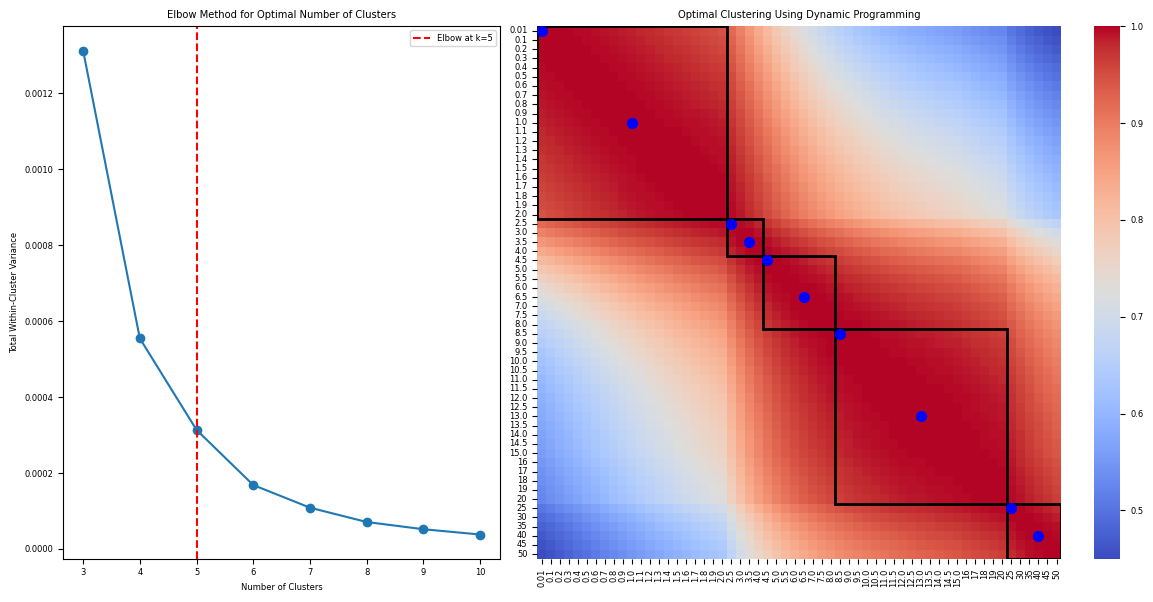

The optimal number of clusters is: 5
Optimal clusters (start, end): [(0, 20), (21, 24), (25, 32), (33, 51), (52, 57)]
Cluster centers: [1.0, 3.5, 6.5, 13.0, 40]
Typical scales: [0.01, 1.0, 2.5, 3.5, 4.5, 6.5, 8.5, 13.0, 25, 40]
Time taken to perform identification of typical scales: 7.2757 seconds


In [5]:
runLabel = 'XeniumLungCancer'
save_path = './results/' + runLabel+'_neighbor10_TEST'

sz_analyzer = sz.MultiscaleAnalysis(adata=adata, runLabel=runLabel, save_path=save_path)
sz_analyzer.multiscale_transform(use_rep='X_nmf', n_neighbors=10)    # scales: use default
sz_analyzer.identify_typical_scales(max_clusters=10, min_clusters=3)

Time taken to perform UMAP and clustering for raw signal: 315.8803 seconds
Time taken to perform clustering for signal at scale 0.01: 196.5381 seconds
Time taken to perform clustering for signal at scale 1.0: 183.9154 seconds
Time taken to perform clustering for signal at scale 2.5: 172.3158 seconds
Time taken to perform clustering for signal at scale 3.5: 140.5068 seconds
Time taken to perform clustering for signal at scale 4.5: 119.3008 seconds
Time taken to perform clustering for signal at scale 6.5: 131.9004 seconds
Time taken to perform clustering for signal at scale 8.5: 108.6707 seconds
Total time: 1053.2426 seconds


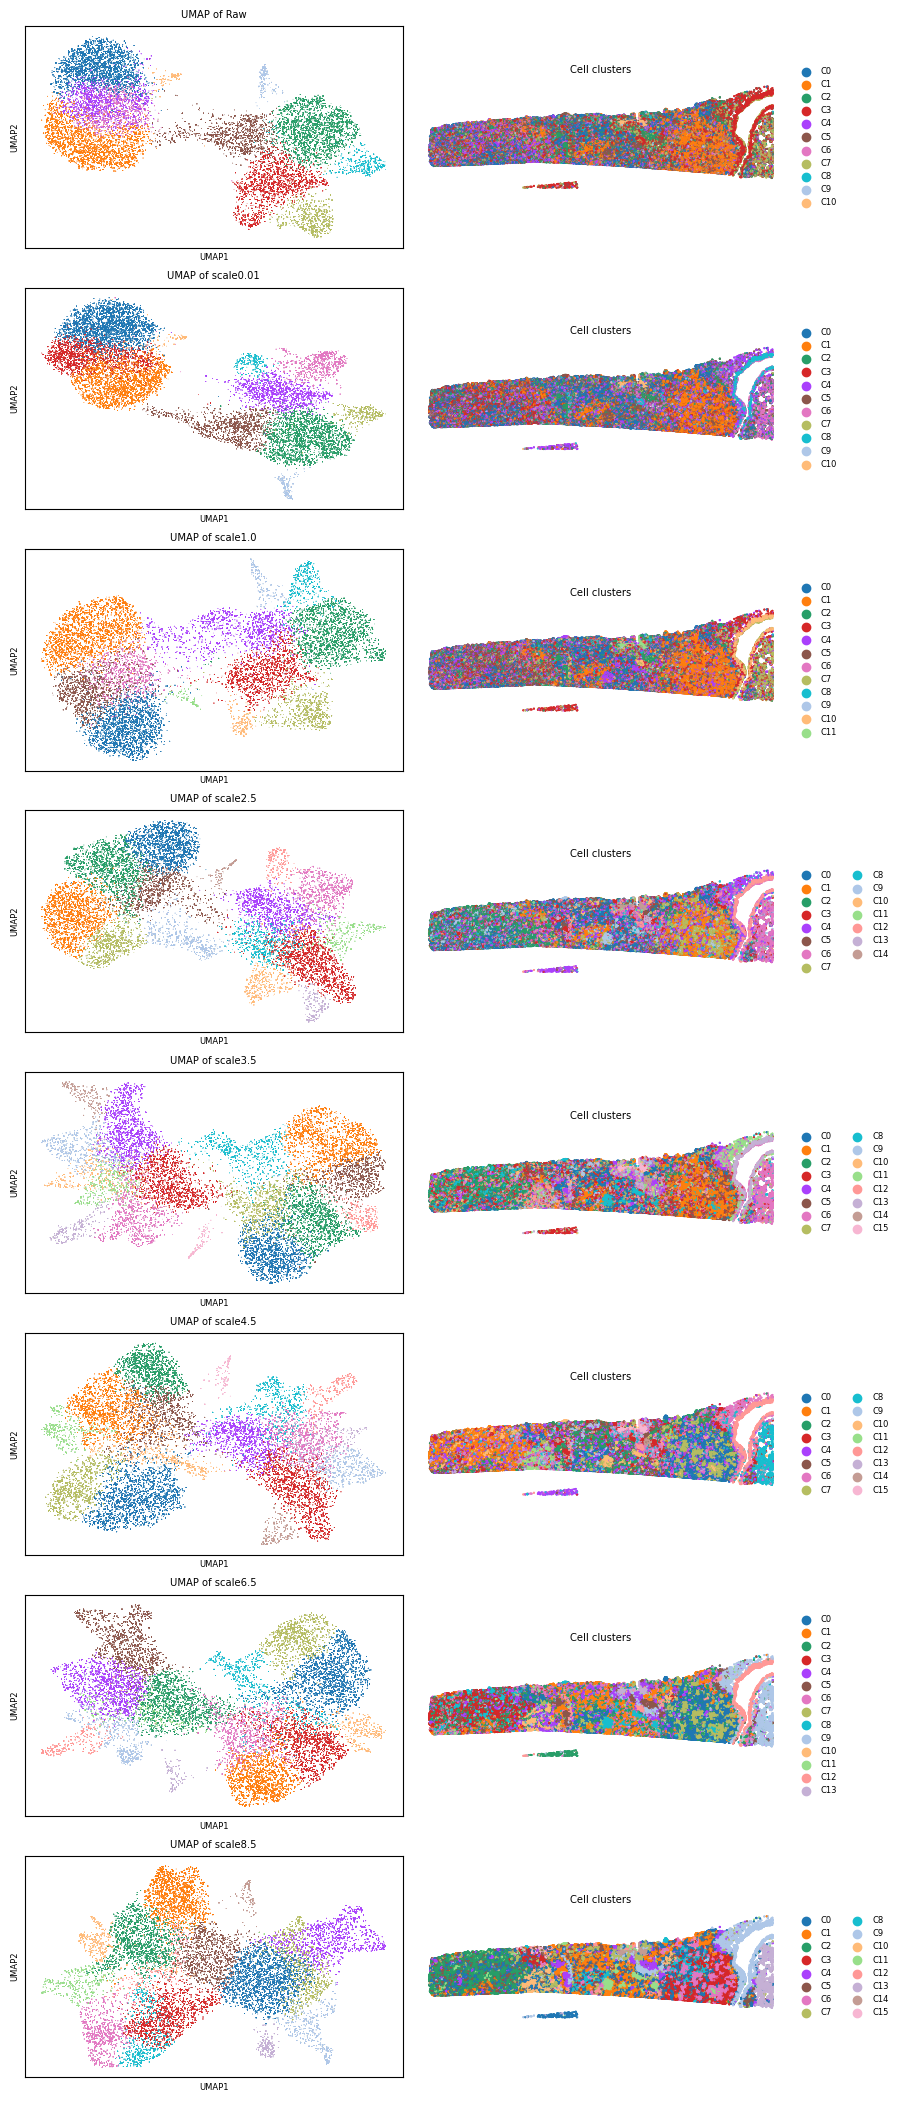

In [6]:
# set max_scale = 10 to process only single cell ~ niche level scales
resolutions = [1]
sz_analyzer.clustering(
    n_clusters_kmeans=10000, 
    resolutions=resolutions, 
    max_scale=10)

sz_analyzer.plot_multiscale_clusters(resolution=resolutions[0])

Maximum similarities:  12498.308
Minimum similarities:  511.5974
Median similarities:  1035.6777
time taken to construct expr_knn: 355.0211 seconds


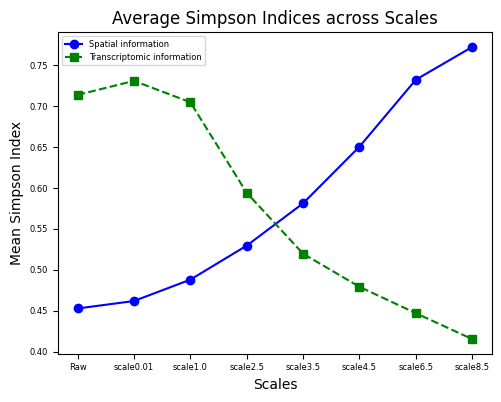

In [7]:
sz_analyzer.plot_simpson()

In [8]:
sz_analyzer.adata.write(save_path + '/XeniumLungCancer_adata_processed.h5ad')